In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleModels as nrn

In [3]:
params_pn = {'tau':20, 'r':100, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':10}
params_pv = {'tau':5, 'r':100, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}

# single cell with poisson input 

In [300]:
nrn.set_times(tmax=100, dt=0.01)

In [22]:
def single_input(tau_r=0.1, tau_d=5, onset=50):
    tau1, tau2 = nrn.convert_tau_rdto12(tau_r, tau_d)
    B = nrn.get_syn_norm(tau_r, tau_d)
    return nrn.f_syn(nrn._times[1:], onset, 0, tau1, tau2, B)

def show_single_result(cell, onset):
    plt.figure(dpi=150, figsize=(6, 3))
    plt.subplot(121)
    plt.plot(nrn._times, cell.vcells, 'k', lw=1)
    yl = plt.gca().get_ylim()
    plt.plot([onset, onset], yl, 'b--', lw=0.7)
    plt.xlabel('time (ms)', fontsize=12)
    plt.ylabel('voltage (mV)', fontsize=12)
    plt.xlim([0, nrn._tmax])
    plt.ylim(yl)
    plt.subplot(122)
    plt.plot(nrn._times[1:], cell.ghat_ext*cell.gbar_ext[0], 'r', lw=1)
    yl = plt.gca().get_ylim()
    plt.plot([onset, onset], yl, 'b--', lw=0.7)
    plt.xlabel('time (ms)', fontsize=12)
    plt.ylabel(r'conductance ($\mu$S)', fontsize=12)
    plt.xlim([0, nrn._tmax])
    plt.ylim(yl)
    plt.tight_layout()
    plt.show()
    
def find_threshold(gs, params):
    vmaxs = []
    vcells = []
    g_exc = single_input(onset=25, tau_r=0.1, tau_d=5)
    e_exc = [0]
    target_id = [[0]]
    for g in gs:
        gbar_exc = [[g]]
        cell_exc = nrn.CellNetwork(**params, g_ext=g_exc, e_ext=e_exc, gbar_ext=gbar_exc, target_id=target_id, syn=None)
        cell_exc.run()
        vmaxs.append(max(cell_exc.vcells[:, 0]))
        vcells.append(cell_exc.vcells[:, 0].copy())
    return vmaxs, vcells

def basic_labeling(title=None):
    plt.xlabel('time (ms)', fontsize=12)
    plt.ylabel('voltage (mV)', fontsize=12)
    plt.title(title, fontsize=15)
    plt.xlim([0, nrn._tmax])
    
def get_spk_hist(spks, t, w=100, m=10):
    n = len(t)
    ids = np.arange(0, n-w+1, m)
    nid = len(ids)
    hist = np.zeros(nid)
    for spk in spks:
        for s0 in spk:
            for n, i0 in enumerate(ids[1:]):
                if s0 < t[i0]:
                    hist[n] += 1
                    break
    x = np.array(t)
    x = x[ids]
    return hist, x

def getFFT(x, idt):
    fx = np.fft.fft(x[idt]) / sum(idt)
    f = np.fft.fftfreq(sum(idt), nrn._dt/(1e3))
    fx = abs(fx[:int(sum(idt)//2)])
    f = f[:int(sum(idt)//2)]
    return f, fx

## excitatory neuron

In [48]:
g_exc = single_input(onset=25, tau_r=0.1, tau_d=5)
e_exc = [0]
target_id = [[0]]

In [49]:
gbar_exc = [[0.1]]

In [50]:
cell_exc = nrn.CellNetwork(**params_pn, g_ext=g_exc, e_ext=e_exc, gbar_ext=gbar_exc, target_id=target_id, syn=None)

In [51]:
cell_exc.run()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43876.00it/s]


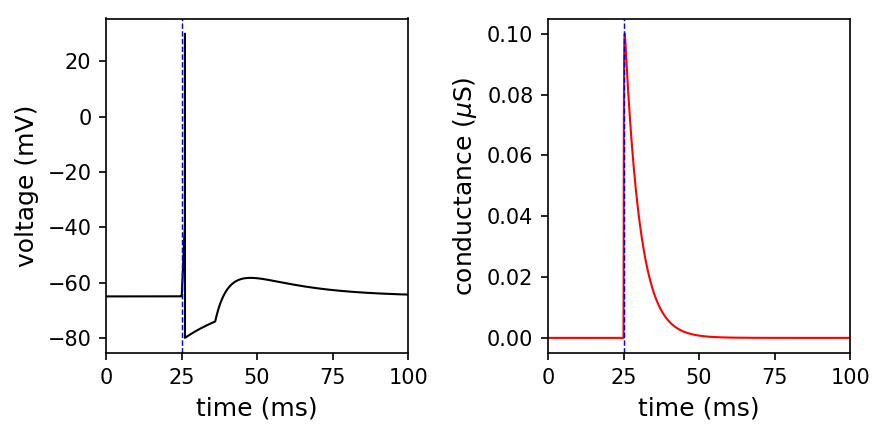

In [90]:
show_single_result(cell_exc, 25)

### find threshold

In [247]:
gs = np.linspace(0, 0.1, 50)
vmaxs, vcells = find_threshold(gs, params_pn)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 44618.97it/s]


In [248]:
# more points
gs2 = np.linspace(0.03, 0.04, 50)
vmaxs2, vcells2 = find_threshold(gs2, params_pn)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 44533.13it/s]


In [251]:
vmaxs_exc_all = np.concatenate((vmaxs, vmaxs2))
vcells_exc_all = np.concatenate((vcells, vcells2))
gs_exc_all = np.concatenate((gs, gs2))

ind = np.argsort(gs_exc_all)
vmaxs_exc_all = vmaxs_exc_all[ind]
vcells_exc_all = vcells_exc_all[ind, :]
gs_exc_all = gs_exc_all[ind]

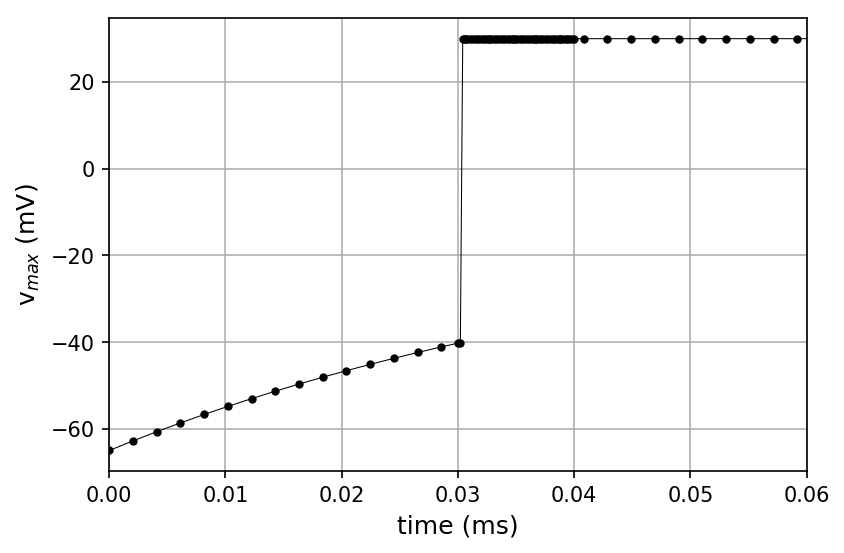

In [253]:
plt.figure(dpi=150)
plt.plot(gs_exc_all, vmaxs_exc_all, 'k.-', lw=0.5)
plt.xlabel('time (ms)', fontsize=12)
plt.ylabel(r'v$_{max}$ (mV)', fontsize=12)
plt.xticks(np.arange(0, 0.11, 0.01))
plt.grid(True)
plt.xlim([0, 0.06])
plt.show()

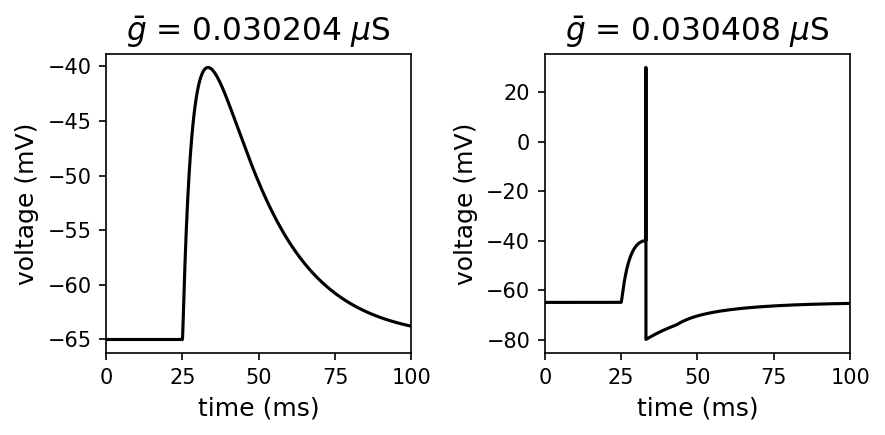

In [272]:
n = 17
plt.figure(dpi=150, figsize=(6, 3))
plt.subplot(121)
plt.plot(nrn._times, vcells_exc_all[n-1, :], 'k-')
basic_labeling(r'$\bar{g}$ = %.6f $\mu$S'%(gs_exc_all[n-1]))
plt.subplot(122)
plt.plot(nrn._times, vcells_exc_all[n, :], 'k-')
basic_labeling(r'$\bar{g}$ = %.6f $\mu$S'%(gs_exc_all[n]))
plt.tight_layout()
plt.show()

## inhibitory neuron

In [301]:
g_exc = single_input(onset=25, tau_r=0.1, tau_d=5)
e_exc = [0]
target_id = [[0]]

In [302]:
gbar_exc = [[0.1]]

In [303]:
cell_inh = nrn.CellNetwork(**params_pv, g_ext=g_exc, e_ext=e_exc, gbar_ext=gbar_exc, target_id=target_id, syn=None)

In [304]:
cell_inh.run()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 44158.42it/s]


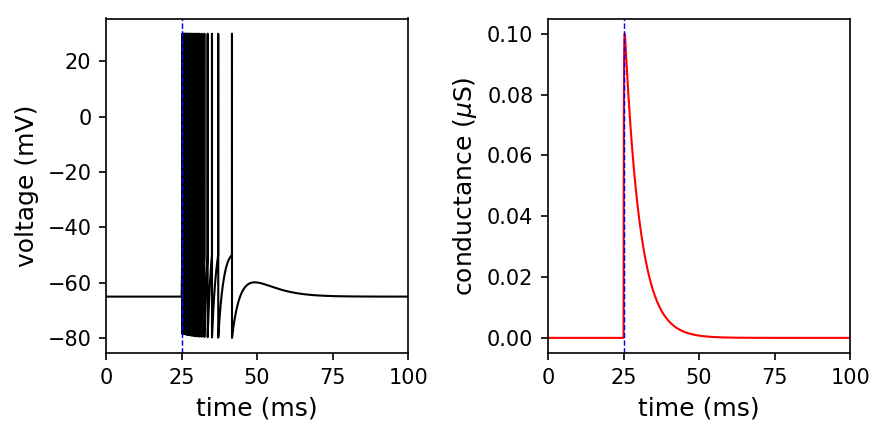

In [305]:
show_single_result(cell_inh, 25)

### find threshold

In [260]:
gs = np.linspace(0, 0.1, 50)
vmaxs, vcells = find_threshold(gs, params_pv)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43173.66it/s]


In [261]:
# more points
gs2 = np.linspace(0.005, 0.01, 50)
vmaxs2, vcells2 = find_threshold(gs2, params_pv)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 44602.13it/s]


In [262]:
vmaxs_inh_all = np.concatenate((vmaxs, vmaxs2))
vcells_inh_all = np.concatenate((vcells, vcells2))
gs_inh_all = np.concatenate((gs, gs2))

ind = np.argsort(gs_inh_all)
vmaxs_inh_all = vmaxs_inh_all[ind]
vcells_inh_all = vcells_inh_all[ind, :]
gs_inh_all = gs_inh_all[ind]

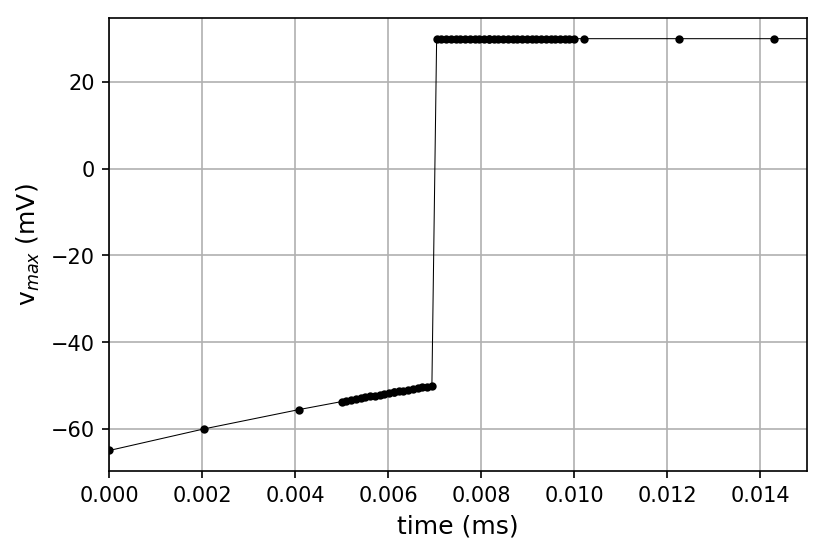

In [270]:
plt.figure(dpi=150)
plt.plot(gs_inh_all, vmaxs_inh_all, 'k.-', lw=0.5)
plt.xlabel('time (ms)', fontsize=12)
plt.ylabel(r'v$_{max}$ (mV)', fontsize=12)
# plt.xticks(np.arange(0, 0.11, 0.01))
plt.xticks(np.arange(0, 0.02, 0.002))
plt.grid(True)
plt.xlim([0, 0.015])
plt.show()

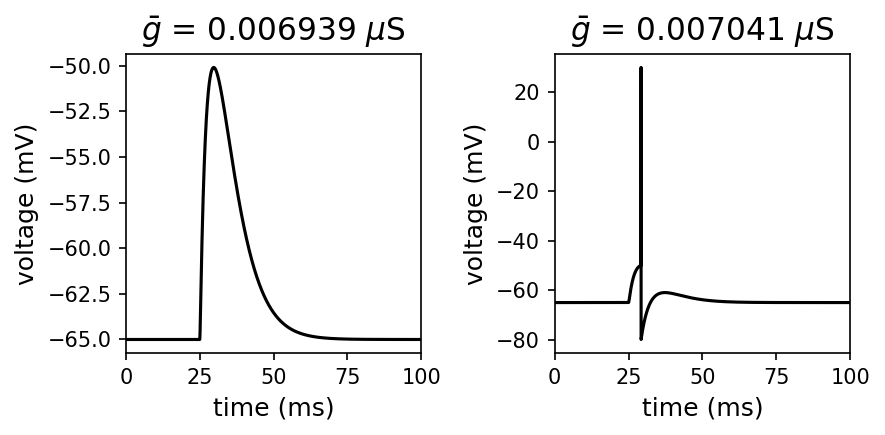

In [273]:
n = 24
plt.figure(dpi=150, figsize=(6, 3))
plt.subplot(121)
plt.plot(nrn._times, vcells_inh_all[n-1, :], 'k-')
basic_labeling(r'$\bar{g}$ = %.6f $\mu$S'%(gs_inh_all[n-1]))
plt.subplot(122)
plt.plot(nrn._times, vcells_inh_all[n, :], 'k-')
basic_labeling(r'$\bar{g}$ = %.6f $\mu$S'%(gs_inh_all[n]))
plt.tight_layout()
plt.show()

# Connect two cell with Poisson input 

In [403]:
nrn.set_times(tmax=1000, dt=0.01)
nrn.set_seed(101227)

In [384]:
# syn_pn2pn = {'gbar_syn':0.01, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pn2pv = {'gbar_syn':0.008, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pv2pn = {'gbar_syn':0.04, 'tau_r':0.1, 'tau_d':5, 'es':-80}
# syn_pv2pv = {'gbar_syn':0.01, 'tau_r':0.1, 'tau_d':5, 'es':-80}

In [379]:
# g_exc -> exc, inh which are mutually connected
g_exc = nrn.gPoisson(0.01, 0.1, 5, delay=0, t0=200, t1=800).T
e_exc = [0]
target_id = [[0, 1]]
gbar_exc = [[0.05, 0.01]]

## exc -> inh

In [404]:
cell_types = [0, 1]
cnt_map = [[-1, 0], [-1, -1]]
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pv, syn_pv2pn],
                         cell_types, cnt_map)

In [405]:
ntk = nrn.CellNetwork(**setting, g_ext=g_exc, e_ext=e_exc, gbar_ext=gbar_exc, target_id=target_id, std=0)
ntk.run()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 23949.18it/s]


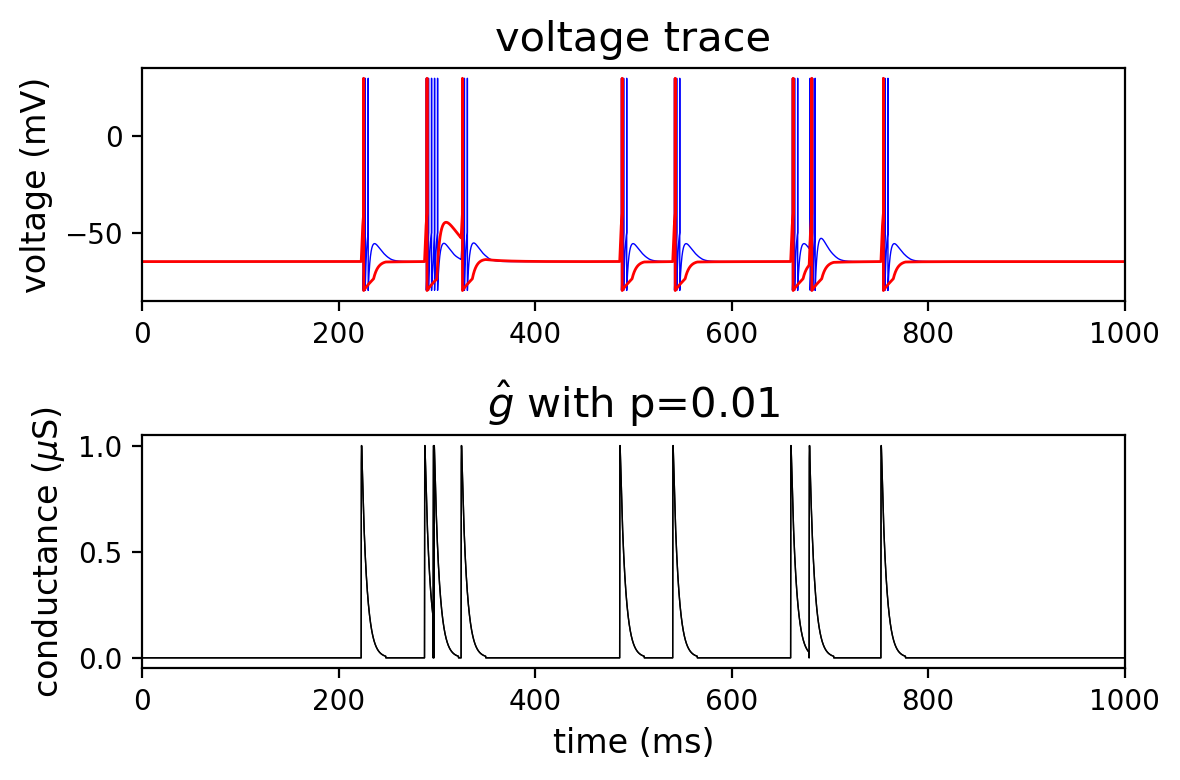

In [406]:
cs = ['r', 'b']
plt.figure(dpi=200, figsize=(6, 4))

plt.subplot(211)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
plt.plot(nrn._times, ntk.vcells[:, 0], 'r', lw=1)    
basic_labeling('voltage trace')
plt.xlabel('')
# plt.xlim([220, 260])

plt.subplot(212)
plt.plot(nrn._times[1:], ntk.ghat_ext, 'k', lw=0.5)
basic_labeling(r'$\hat{g}$ with p=0.01')
plt.ylabel(r'conductance ($\mu$S)')

plt.tight_layout()
plt.show()

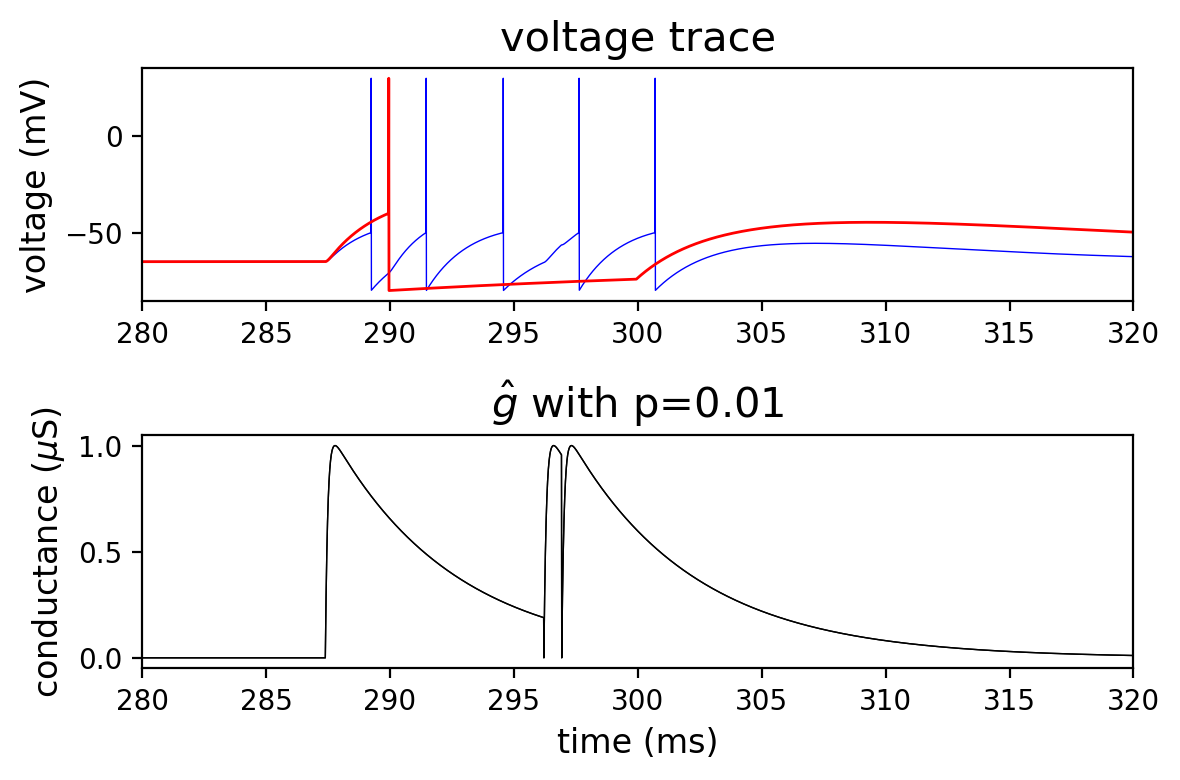

In [407]:
cs = ['r', 'b']
plt.figure(dpi=200, figsize=(6, 4))

plt.subplot(211)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
plt.plot(nrn._times, ntk.vcells[:, 0], 'r', lw=1)    
basic_labeling('voltage trace')
plt.xlabel('')
plt.xlim([280, 320])

plt.subplot(212)
plt.plot(nrn._times[1:], ntk.ghat_ext, 'k', lw=0.5)
basic_labeling(r'$\hat{g}$ with p=0.01')
plt.ylabel(r'conductance ($\mu$S)')
plt.xlim([280, 320])

plt.tight_layout()
plt.show()

## inh -> exc

In [408]:
nrn.set_seed(101227)

In [409]:
cell_types = [0, 1]
cnt_map = [[-1, -1], [1, -1]]
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pv, syn_pv2pn],
                         cell_types, cnt_map)

In [410]:
ntk = nrn.CellNetwork(**setting, g_ext=g_exc, e_ext=e_exc, gbar_ext=gbar_exc, target_id=target_id, std=0)
ntk.run()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 23974.75it/s]


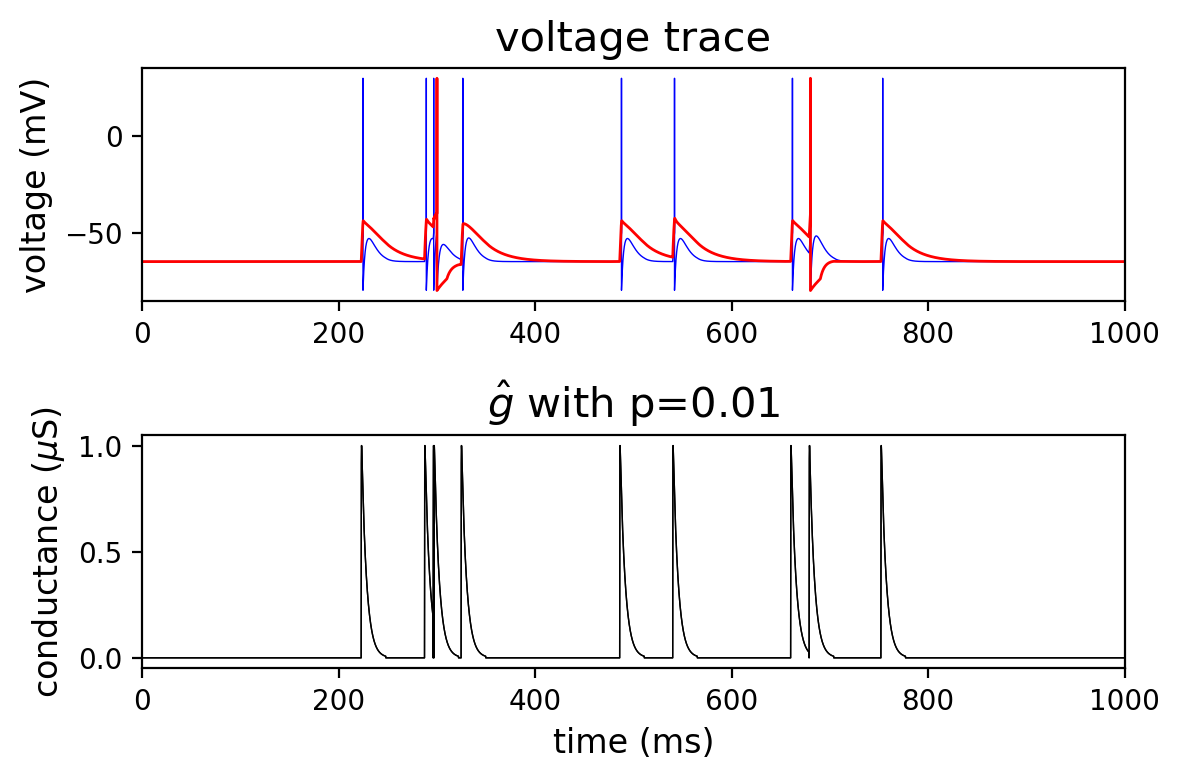

In [411]:
cs = ['r', 'b']
plt.figure(dpi=200, figsize=(6, 4))

plt.subplot(211)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
plt.plot(nrn._times, ntk.vcells[:, 0], 'r', lw=1)    
basic_labeling('voltage trace')
plt.xlabel('')
# plt.xlim([220, 260])

plt.subplot(212)
plt.plot(nrn._times[1:], ntk.ghat_ext, 'k', lw=0.5)
basic_labeling(r'$\hat{g}$ with p=0.01')
plt.ylabel(r'conductance ($\mu$S)')

plt.tight_layout()
plt.show()

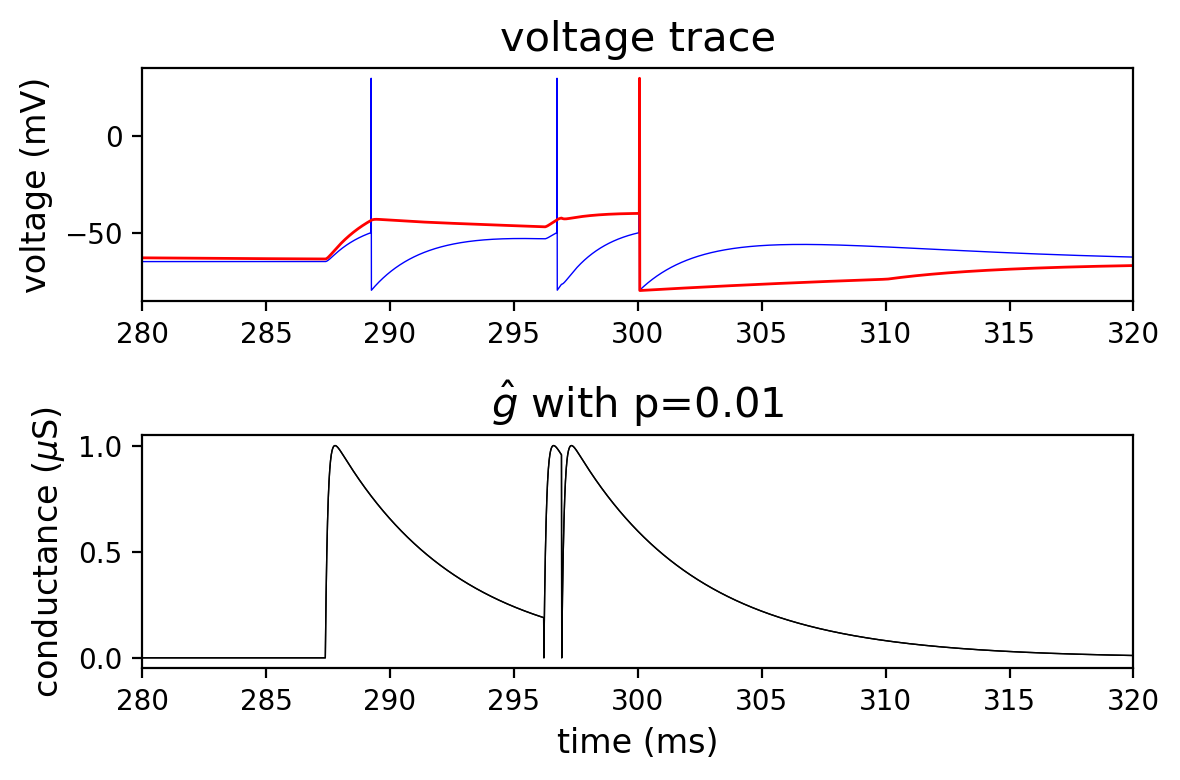

In [412]:
cs = ['r', 'b']
plt.figure(dpi=200, figsize=(6, 4))

plt.subplot(211)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
plt.plot(nrn._times, ntk.vcells[:, 0], 'r', lw=1)    
basic_labeling('voltage trace')
plt.xlabel('')
plt.xlim([280, 320])

plt.subplot(212)
plt.plot(nrn._times[1:], ntk.ghat_ext, 'k', lw=0.5)
basic_labeling(r'$\hat{g}$ with p=0.01')
plt.ylabel(r'conductance ($\mu$S)')
plt.xlim([280, 320])

plt.tight_layout()
plt.show()

## exc <-> inh

In [413]:
nrn.set_seed(101227)

In [414]:
cell_types = [0, 1]
cnt_map = [[-1, 0], [1, -1]]
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pv, syn_pv2pn],
                         cell_types, cnt_map)

In [415]:
ntk = nrn.CellNetwork(**setting, g_ext=g_exc, e_ext=e_exc, gbar_ext=gbar_exc, target_id=target_id, std=0)
ntk.run()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 23501.29it/s]


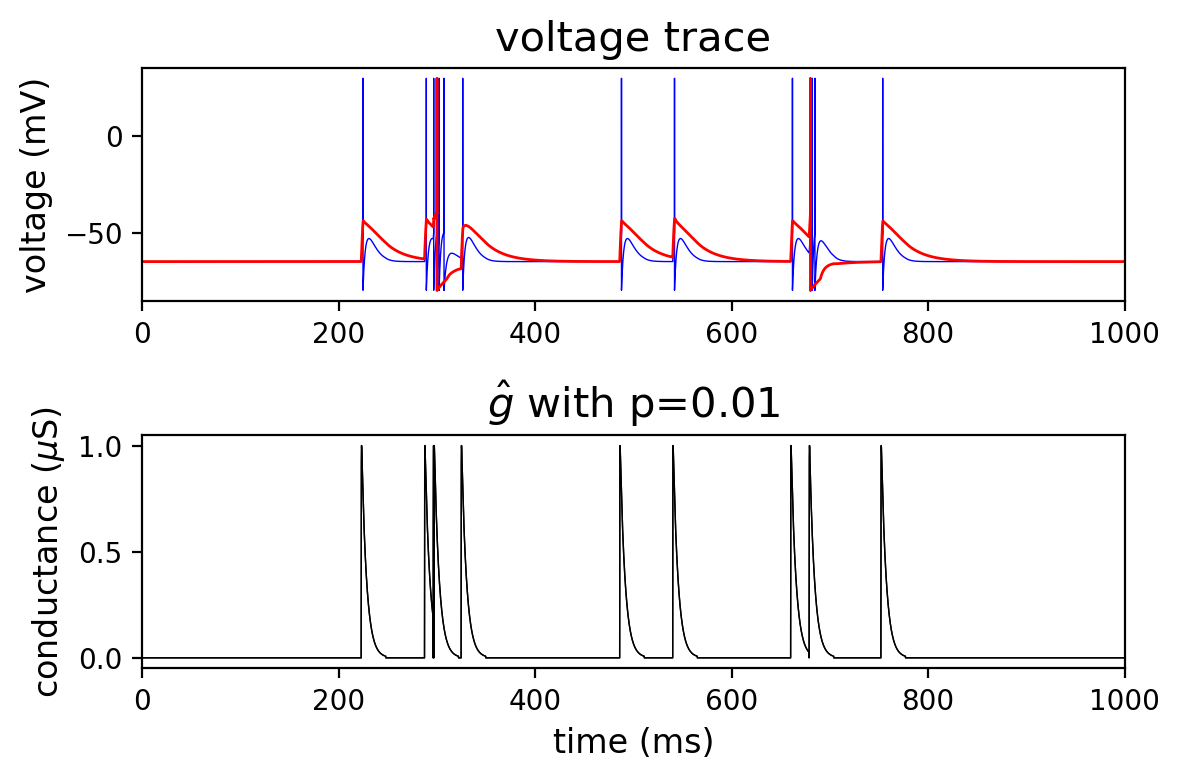

In [416]:
cs = ['r', 'b']
plt.figure(dpi=200, figsize=(6, 4))

plt.subplot(211)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
plt.plot(nrn._times, ntk.vcells[:, 0], 'r', lw=1)    
basic_labeling('voltage trace')
plt.xlabel('')
# plt.xlim([220, 260])

plt.subplot(212)
plt.plot(nrn._times[1:], ntk.ghat_ext, 'k', lw=0.5)
basic_labeling(r'$\hat{g}$ with p=0.01')
plt.ylabel(r'conductance ($\mu$S)')

plt.tight_layout()
plt.show()

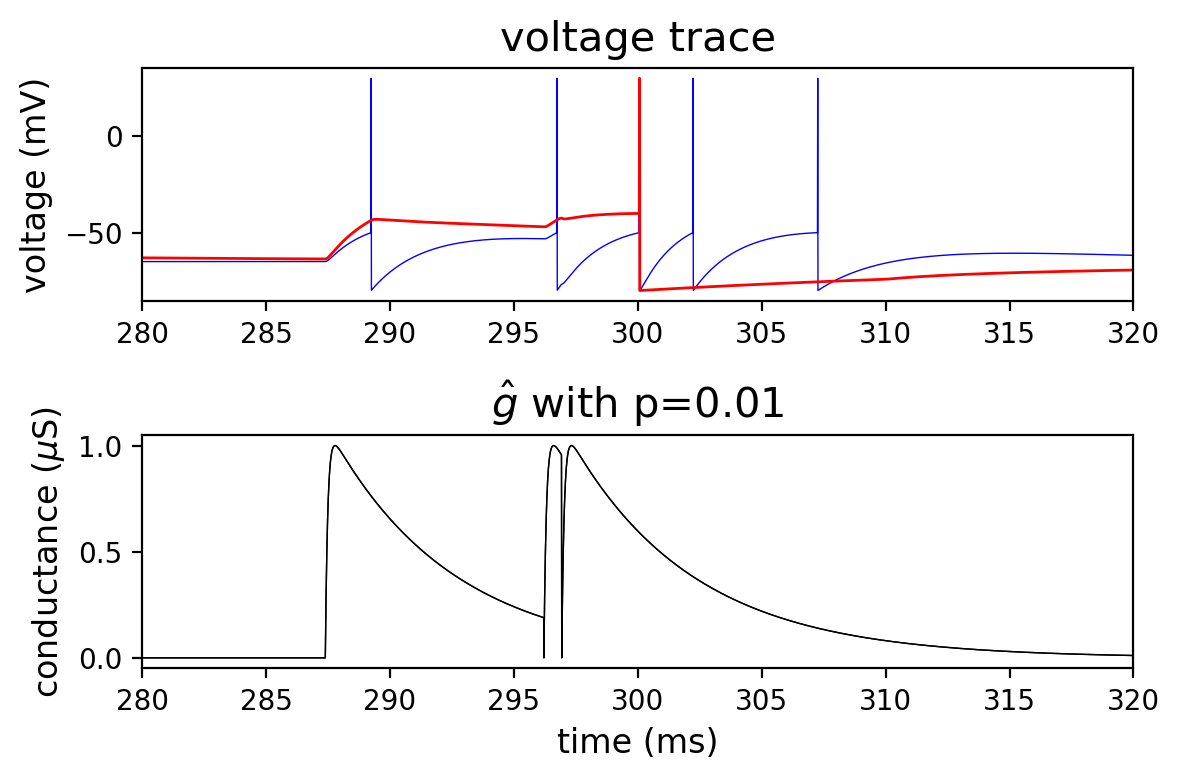

In [417]:
cs = ['r', 'b']
plt.figure(dpi=200, figsize=(6, 4))

plt.subplot(211)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
plt.plot(nrn._times, ntk.vcells[:, 0], 'r', lw=1)    
basic_labeling('voltage trace')
plt.xlabel('')
plt.xlim([280, 320])

plt.subplot(212)
plt.plot(nrn._times[1:], ntk.ghat_ext, 'k', lw=0.5)
basic_labeling(r'$\hat{g}$ with p=0.01')
plt.ylabel(r'conductance ($\mu$S)')
plt.xlim([280, 320])

plt.tight_layout()
plt.show()